# Сегментация изображений

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet101, DenseNet121
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output



#tf.config.experimental.set_visible_devices([], 'GPU')

In [2]:
#from tensorflow.python.client import device_lib;print(device_lib.list_local_devices())

In [3]:
# Это наша метрика на Tensorflow
def dice_coef(y_true, y_pred):
    return (2. * tf.math.reduce_sum(y_true * y_pred) + 1.) / (tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + 1.)

In [4]:
# Загрузка датасета Oxford-IIIT Pets
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteU7EC44/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteU7EC44/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [114]:
#нормализация к 0 и 1.
#Пиксели сегментационной маски будут помечены {0, 1, 2}
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1

    return input_image, input_mask

#аугментация данных посредством переворота изображений.  
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask


def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [108]:
#Датасет уже содержит необходимые тестовый и тренеровочный сплиты, поэтому будем использовать их.
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)


In [109]:
#Рассмотрим изображение из датасета и соответствующую ему маску из датасета.
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()


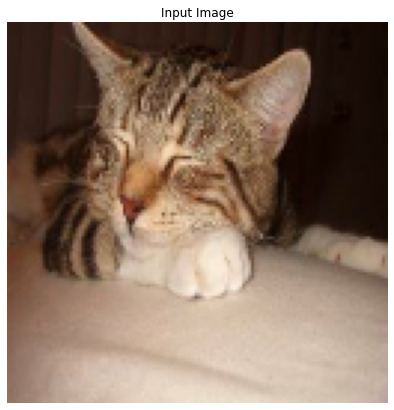

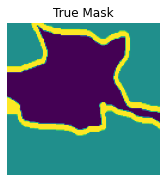

In [110]:
for image, mask in train.take(10):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

# Практическое задание

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в
комментариях, какого результата вы добились от нейросети, что помогло
улучшить её точность?

In [111]:
#Определение модели U-Net
def get_model(img_size=[128, 128, 3], num_classes=3):

    input = Input(shape=img_size)

    
    x1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x1)
    x1 = BatchNormalization()(x1)
    
    x2 = Conv2D(32, (3, 3), strides=2,  activation = 'relu', padding = 'same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x2)
    x2 = BatchNormalization()(x2)
    
    x3 = Conv2D(64, (3, 3), strides=2, activation = 'relu', padding = 'same')(x2)
    x3 = BatchNormalization()(x3)
    x3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x3)
    x3 = BatchNormalization()(x3)
    x3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x3)
    x3 = BatchNormalization()(x3)
    
    x4 = Conv2D(128, (3, 3), strides=2, activation = 'relu', padding = 'same')(x3)
    x4 = BatchNormalization()(x4)
    x4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(x4)
    x4 = BatchNormalization()(x4)
    x4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(x4)
    x4 = BatchNormalization()(x4)
    
    x5 = Conv2D(256, (3, 3), strides=2, activation = 'relu', padding = 'same')(x4)
    x5 = BatchNormalization()(x5)
    x5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(x5)
    x5 = BatchNormalization()(x5)
    x5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(x5)
    x5 = BatchNormalization()(x5)

    x6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(x5), x4], axis = 3)
    x6 = BatchNormalization()(x6)
    x6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(x6)
    x6 = BatchNormalization()(x6)
    xv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(x6)
    x6 = BatchNormalization()(x6)

    x7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(x6), x3], axis = 3)
    x7 = BatchNormalization()(x7)
    x7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x7)
    x7 = BatchNormalization()(x7)
    x7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x7)
    x7 = BatchNormalization()(x7)

    x8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(x7), x2], axis = 3)
    x8 = BatchNormalization()(x8)
    x8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x8)
    x8 = BatchNormalization()(x8)
    x8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x8)
    x8 = BatchNormalization()(x8)

    x9 = concatenate([Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(x8), x1], axis = 3)
    x9 = BatchNormalization()(x9)
    x9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x9)
    x9 = BatchNormalization()(x9)
    x9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x9)
    x9 = BatchNormalization()(x9)

    output = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x9)
    
    model = Model(input, output)

    model.compile(optimizer=Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[dice_coef])

    return model

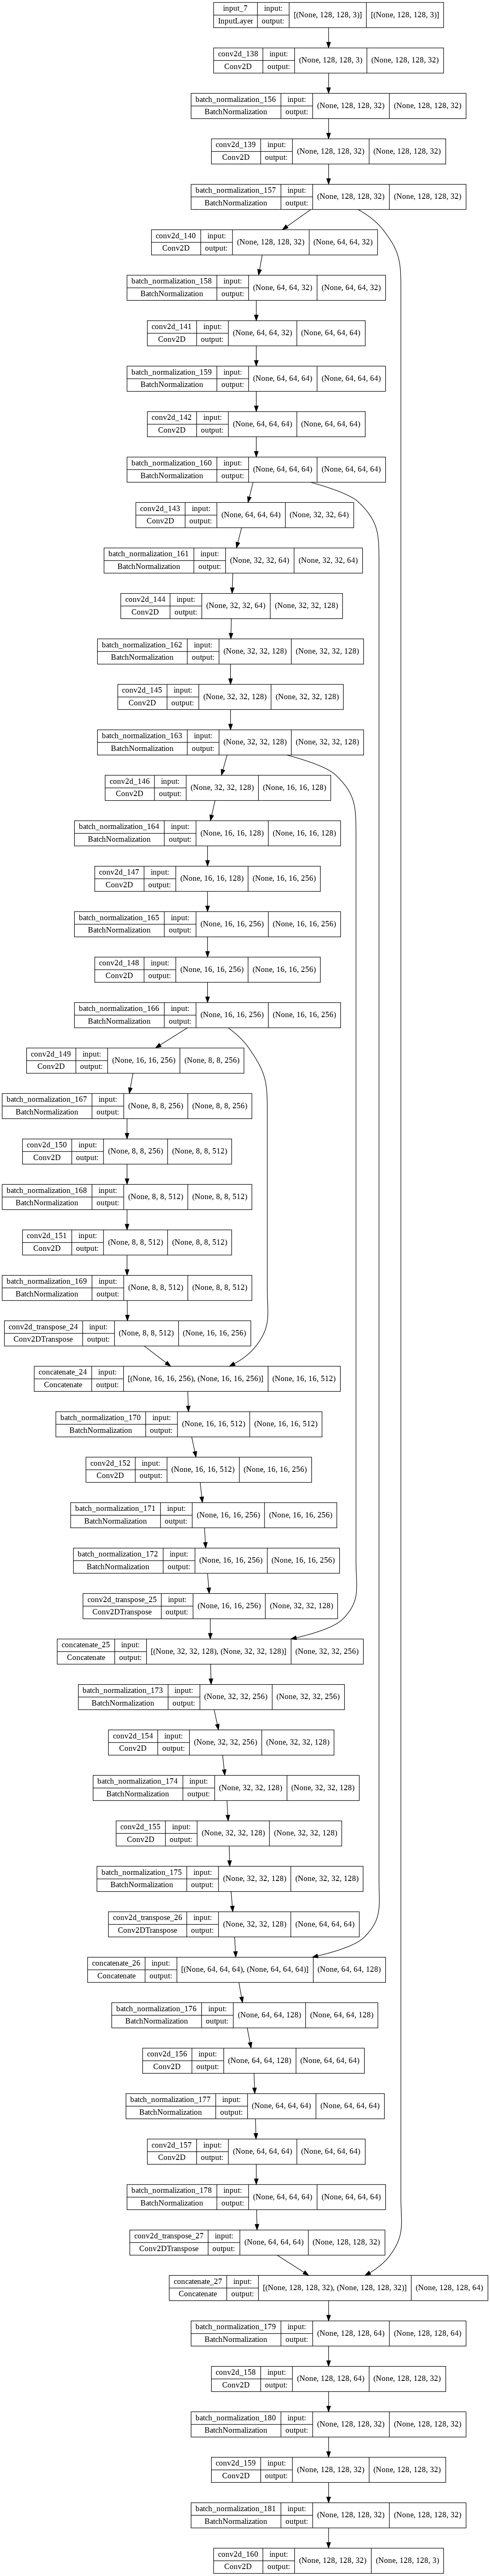

In [124]:
model = get_model()
utils.plot_model(model,'model_stek.png', show_shapes=True)

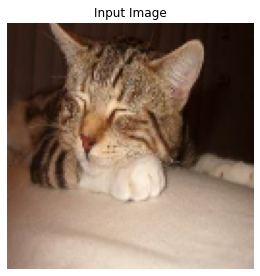

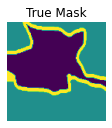

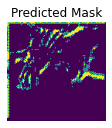

In [125]:
#С помощью модели попробуем сделать предсказание до того, как началось обучение
show_predictions()

In [126]:
# Пишем свой обратный вызов. Он только для визуализации результатов работы эпохи   
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=5):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
    
    def display(self, display_list, extra_title=''):
        display([display_list[0], display_list[1],display_list[2]])
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = pred_mask[..., tf.newaxis]
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=3):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions(self.dataset)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))



Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 6/57 [==>...........................] - ETA: 19s - loss: 1.2524 - dice_coef: 0.8969WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1357s vs `on_train_batch_end` time: 0.2471s). Check your callbacks.


57/57 [==============================] - 30s 428ms/step - loss: 0.8097 - dice_coef: 0.8974 - val_loss: 166.9794 - val_dice_coef: 0.9026
Epoch 2/20
57/57 [==============================] - 24s 431ms/step - loss: 0.5761 - dice_coef: 0.8977 - val_loss: 5.2628 - val_dice_coef: 0.9026
Epoch 3/20
57/57 [==============================] - 24s 428ms/step - loss: 0.5185 - dice_coef: 0.8981 - val_loss: 1.4332 - val_dice_coef: 0.9026
Epoch 4/20
57/57 [==============================] - 24s 421ms/step - loss: 0.4497 - dice_coef: 0.8967 - val_loss: 2.4752 - val_dice_coef: 0.9026
Epoch 5/20
57/57 [==============================] - 24s 423ms/step - loss: 0.4098 - dice_coef: 0.8975 - val_loss: 1.0609 - val_dice_coef: 0.9026
Epoch 6/20
57/57 [==============================] - ETA: 0s - loss: 0.3731 - dice_coef: 0.8981

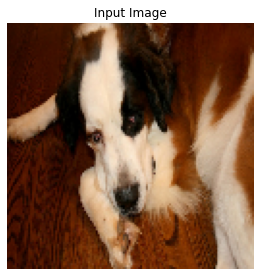

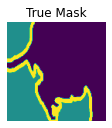

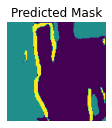

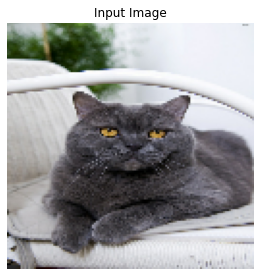

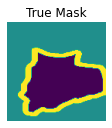

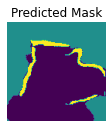

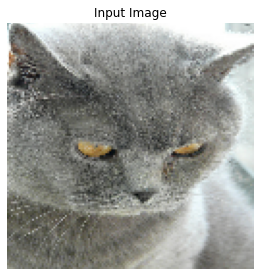

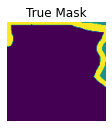

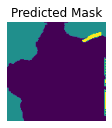


Sample Prediction after epoch 6

57/57 [==============================] - 26s 453ms/step - loss: 0.3731 - dice_coef: 0.8981 - val_loss: 0.9831 - val_dice_coef: 0.9026
Epoch 7/20
57/57 [==============================] - 24s 427ms/step - loss: 0.3575 - dice_coef: 0.8953 - val_loss: 1.0550 - val_dice_coef: 0.9026
Epoch 8/20
57/57 [==============================] - 24s 425ms/step - loss: 0.3355 - dice_coef: 0.8970 - val_loss: 0.4999 - val_dice_coef: 0.9026
Epoch 9/20
57/57 [==============================] - 24s 426ms/step - loss: 0.3133 - dice_coef: 0.8991 - val_loss: 0.5601 - val_dice_coef: 0.9026
Epoch 10/20
57/57 [==============================] - 24s 425ms/step - loss: 0.3020 - dice_coef: 0.8980 - val_loss: 0.4631 - val_dice_coef: 0.9026
Epoch 11/20
57/57 [==============================] - ETA: 0s - loss: 0.2856 - dice_coef: 0.8977

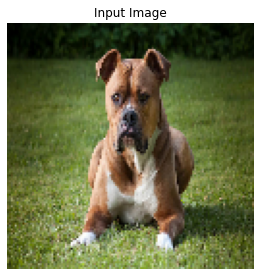

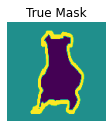

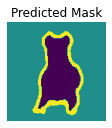

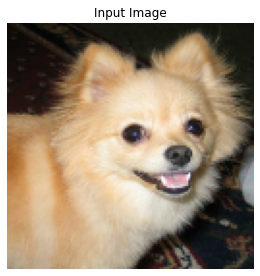

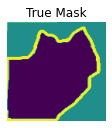

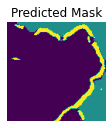

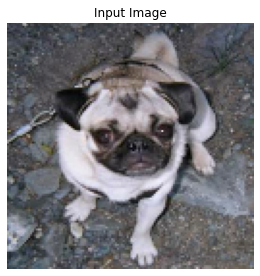

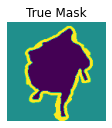

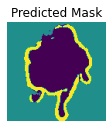


Sample Prediction after epoch 11

57/57 [==============================] - 27s 469ms/step - loss: 0.2856 - dice_coef: 0.8977 - val_loss: 0.3907 - val_dice_coef: 0.9026
Epoch 12/20
57/57 [==============================] - 24s 424ms/step - loss: 0.2641 - dice_coef: 0.8962 - val_loss: 0.3607 - val_dice_coef: 0.9026
Epoch 13/20
57/57 [==============================] - 24s 429ms/step - loss: 0.2585 - dice_coef: 0.8986 - val_loss: 0.4104 - val_dice_coef: 0.9026
Epoch 14/20
57/57 [==============================] - 24s 427ms/step - loss: 0.2634 - dice_coef: 0.8984 - val_loss: 0.4515 - val_dice_coef: 0.9026
Epoch 15/20
57/57 [==============================] - 24s 428ms/step - loss: 0.2436 - dice_coef: 0.8958 - val_loss: 0.5199 - val_dice_coef: 0.9026
Epoch 16/20
57/57 [==============================] - ETA: 0s - loss: 0.2230 - dice_coef: 0.8975

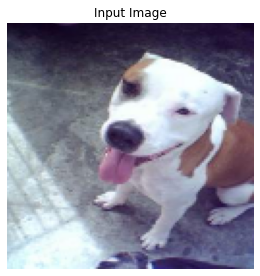

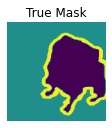

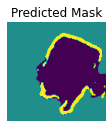

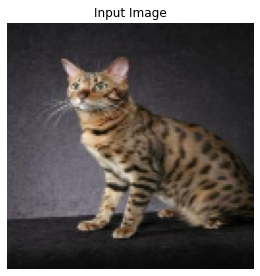

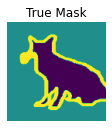

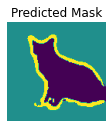

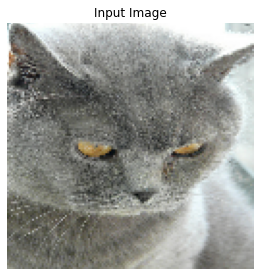

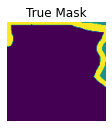

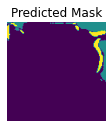


Sample Prediction after epoch 16

57/57 [==============================] - 25s 446ms/step - loss: 0.2230 - dice_coef: 0.8975 - val_loss: 0.3642 - val_dice_coef: 0.9026
Epoch 17/20
57/57 [==============================] - 24s 426ms/step - loss: 0.2160 - dice_coef: 0.8980 - val_loss: 0.3964 - val_dice_coef: 0.9026
Epoch 18/20
57/57 [==============================] - 24s 426ms/step - loss: 0.2188 - dice_coef: 0.8980 - val_loss: 0.4451 - val_dice_coef: 0.9026
Epoch 19/20
57/57 [==============================] - 24s 428ms/step - loss: 0.2051 - dice_coef: 0.8976 - val_loss: 0.3712 - val_dice_coef: 0.9026
Epoch 20/20
57/57 [==============================] - 24s 426ms/step - loss: 0.1975 - dice_coef: 0.8966 - val_loss: 0.3685 - val_dice_coef: 0.9026


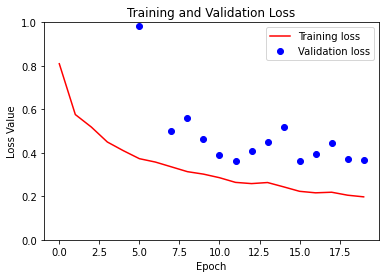

In [127]:
# Обучим модель
EPOCHS = 20 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

with tf.device("GPU:0"):#"CPU:0"
    model_history = model.fit(train_dataset, 
                            epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            validation_data=test_dataset,
                            callbacks=[DisplayCallback(train_dataset, epoch_interval=5)])

loss = model_history.history['loss']

val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Сделаем несколько предсказаний

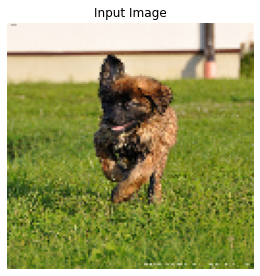

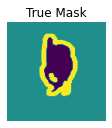

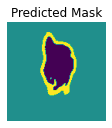

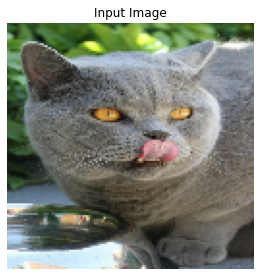

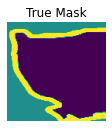

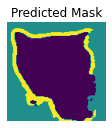

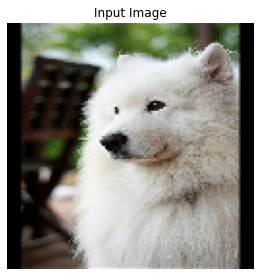

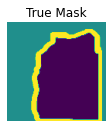

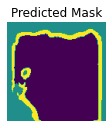

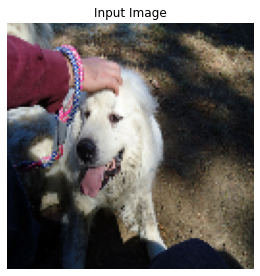

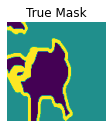

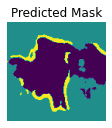

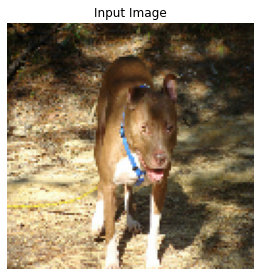

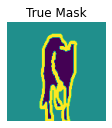

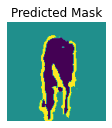

In [128]:
show_predictions(test_dataset, 5)

#### Вывод: чем сложнее модель, тем более точный вывод она выдаёт, но и больше ресурсов тратит на своё обучение. 